# Genetic Algorithms and Finance
Attempted implementation of https://drive.google.com/file/d/0B9-kA56h5JCMMW4tU25HRExWb1U/view?usp=sharing

TODO: Test out of sample performance of strategies

## Data Gathering

In [195]:
import pandas as pd

#S&P 500 returns
#SPY data from yahoo finance https://finance.yahoo.com/quote/%5EGSPC/history?period1=-631130400&period2=1544248800&interval=1d&filter=history&frequency=1d
SPY = pd.read_csv('SPY.csv', parse_dates = True)
SPY["Returns"] = (SPY["Close"] - SPY["Close"].shift(1))/SPY["Close"].shift(1)
SPY["Date"] = pd.to_datetime(SPY["Date"])
data = SPY.set_index("Date")
data = data.dropna()
print(type(data.index[0]))
data.head()

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


,Open,High,Low,Close,Adj Close,Volume,Returns
Date,,,,,,,
1950-01-04,16.850000,16.850000,16.850000,16.850000,16.850000,1890000,0.011405
1950-01-05,16.930000,16.930000,16.930000,16.930000,16.930000,2550000,0.004748
1950-01-06,16.980000,16.980000,16.980000,16.980000,16.980000,2010000,0.002953
1950-01-09,17.080000,17.080000,17.080000,17.080000,17.080000,2520000,0.005889
1950-01-10,17.030001,17.030001,17.030001,17.030001,17.030001,2160000,-0.002927


In [196]:
#True on the index that a crosses over b
def crossover(a, b):
    a.dropna(inplace = True)
    if not isinstance(b, pd.Series):
        b = pd.Series(b, index = a.index)
    else:
        b.dropna(inplace = True)
    minDate = max(a.index[0], b.index[0])
    maxDate = min(a.index[-1], b.index[-1])
    a = a[minDate:maxDate]
    b = b[minDate:maxDate]
    previousPeriodLessThan = a.shift(1) < b.shift(1) #check if in the previous day, a was less than b
    nextPeriodGreaterThan = a > b #in the day after the previous day ("today") a is greater than b
    out = previousPeriodLessThan & nextPeriodGreaterThan
    return out

#True on the index that a crosses under b
def crossunder(a, b):
    a.dropna(inplace = True)
    if not isinstance(b, pd.Series):
        b = pd.Series(b, index = a.index)
    else:
        b.dropna(inplace = True)
    minDate = max(a.index[0], b.index[0])
    maxDate = min(a.index[-1], b.index[-1])
    a = a[minDate:maxDate]
    b = b[minDate:maxDate]
    previousPeriodLessThan = a.shift(1) > b.shift(1) #check if in the previous day, a was less than b
    nextPeriodGreaterThan = a < b #in the day after the previous day ("today") a is greater than b
    out = previousPeriodLessThan & nextPeriodGreaterThan
    return out

Indicators: SMA, MACD, Slow Stochastic, RSI, CCI,
Momentum Oscillator, Price Oscillator, Larry Williams, Bollinger Bands and OBV.

In [197]:
import talib
import pandas as pd
close = data.Close
high = data.High
low = data.Low
volume = data.Volume

indicators = []

#Class that holds the buy and sell signals for a given indicator
class Indicator:
    def __init__(self, name, buy, sell):
        self.name = name
        self.buy = buy.dropna()
        self.sell = sell.dropna()
        self.minDate = buy.index[0]
        self.maxDate = buy.index[-1]
    
    def get(self, side):
        if side == "buy":
            return self.buy
        elif side == "sell":
            return self.sell
        else:
            raise("Side must be either buy or sell")

# Generating Indicators/Signals
Generate the desired technical indicators and their binary buy and sell signals, stored as an Indicator instance in the global list indicators

In [198]:
#SMA
SMA50 = talib.SMA(close, 50)
SMA200 = talib.SMA(close, 200)
buy = crossover(SMA50, SMA200)
sell = crossunder(SMA50, SMA200)
SMA = Indicator("SMA", buy, sell)
indicators.append(SMA)

In [199]:
#MACD
macd, macdsignal, macdhist = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
buy = crossover(macd, macdsignal)
sell = crossunder(macd, macdsignal)
MACD = Indicator("MACD", buy, sell)
indicators.append(MACD)

In [200]:
#RSI
rsi = talib.RSI(close, 14)
buy = crossover(rsi, 30)
sell = crossunder(rsi, 70)
RSI = Indicator("RSI", buy, sell)
indicators.append(RSI)

In [201]:
#CCI
CCI = talib.CCI(high, low, close, timeperiod=14)
buy = crossover(CCI, 100)
sell = crossunder(CCI, -100)
CCI = Indicator("CCI", buy, sell)
indicators.append(CCI)

In [202]:
#Momentum Oscillator
MOM = talib.MOM(close, 9)
buy = crossover(MOM, 100)
sell = crossunder(MOM, 100)
MOM = Indicator("MOM", buy, sell)
indicators.append(MOM)

In [203]:
#Price Oscillator
#Couldn't find

In [204]:
#Williams %R
Williams = talib.WILLR(high, low, close, timeperiod=14)
sell = crossover(Williams, -20)
buy = crossunder(Williams, -80)
Williams = Indicator("Williams %R", buy, sell)
indicators.append(Williams)

In [205]:
#Bollinger Bands
upperband, middleband, lowerband = talib.BBANDS(close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
buy = crossover(middleband, lowerband)
sell = crossunder(middleband, upperband)
bollinger = Indicator("Bollinger Bands", buy, sell)
indicators.append(bollinger)

In [206]:
#OBV
OBV = talib.OBV(close, volume)
OBV_signal = talib.SMA(OBV, 20)
buy = crossover(OBV, OBV_signal)
sell = crossunder(OBV, OBV_signal)
OBV = Indicator("OBV", buy, sell)
indicators.append(OBV)

In [207]:
minDate = max([indicator.buy.index[0] for indicator in indicators])
print(type(indicators[0].buy.index[0]))
maxDate = min([indicator.buy.index[-1] for indicator in indicators])
print("minDate " + str(minDate))
print("maxDate " + str(maxDate))
for i in range(len(indicators)):
    print(indicators[i].name)
    indicators[i].buy = indicators[i].buy[minDate:maxDate]
    indicators[i].sell = indicators[i].sell[minDate:maxDate]

data = data[minDate:maxDate]

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
minDate 1950-10-19 00:00:00
maxDate 2018-12-07 00:00:00
SMA
MACD
RSI
CCI
MOM
Williams %R
Bollinger Bands
OBV


# Genetic Algorithm
TradingRule is a rule to either buy or sell a stock

TradingStrategy is composed of two trading rules, one for buying, one for selling

Population is a collection of TradingStrategies

GeneticAlgorithm is a class to execute the genetic algorithm

In [208]:
class TradingRule:
    #A trading rule has 5 indicators, 5 directions, and 4 operators = 14 components
    NO_INDICATORS = 5
    BOOLEAN_OPERATORS = ["and", "or", "xor"]
    
    def setIndicators(self):
        self.indicators = np.random.randint(len(indicators), size=TradingRule.NO_INDICATORS)
        return
    
    def printIndicators(self):
        for i in self.indicators:
            print(indicators[i].name)
    
    def setBooleanOperators(self):
        self.operators = np.random.randint(len(TradingRule.BOOLEAN_OPERATORS), size=TradingRule.NO_INDICATORS-1)
        self.operatorsStr = []
        for i in self.operators:
            self.operatorsStr.append(TradingRule.BOOLEAN_OPERATORS[i])
        return
    
    def setIndicatorDirections(self):
        self.indicatorDirections = np.random.randint(2, size=TradingRule.NO_INDICATORS)
        self.indicatorDirectionsStr = []
        for i in range(TradingRule.NO_INDICATORS):
            direction = self.indicatorDirections[i]
            if direction == 0:
                self.indicatorDirectionsStr.append("sell")
            elif direction == 1:
                self.indicatorDirectionsStr.append("buy")
            else:
                print(direction)
                raise("Indicator Direction isn't 0 or 1")
        return

    def __init__(self, side):
        self.side = side
        self.setIndicators()
        self.setBooleanOperators()
        self.setIndicatorDirections()
        return
    
    def print(self):
        out = ""
        for i in range(TradingRule.NO_INDICATORS):
            if i < TradingRule.NO_INDICATORS-1:
                out = out + indicators[self.indicators[i]].name + "-" + self.indicatorDirectionsStr[i] + " " + self.operatorsStr[i] + " "
            else:
                out = out + indicators[self.indicators[i]].name + "-" + self.indicatorDirectionsStr[i]
        print(out)
        return
    
    def generateSignals(self):
        out = indicators[self.indicators[0]].get(self.indicatorDirectionsStr[0])
        for i in range(len(self.operatorsStr)):
            operator = self.operatorsStr[i]
            if operator == "and":
                out = out & indicators[self.indicators[1+i]].get(self.indicatorDirectionsStr[1+i])
            elif operator == "or":
                out = out | indicators[self.indicators[1+i]].get(self.indicatorDirectionsStr[1+i])
            elif operator == "xor":
                out = out ^ indicators[self.indicators[1+i]].get(self.indicatorDirectionsStr[1+i])
            else:
                raise("Invalid operator")
        self.signal = out
        return
    
    def getGenotype(self):
        genotype = []
        genotype.append(self.indicators[0])
        genotype.append(self.indicatorDirections[0])
        for i in range(len(self.operators)):
            genotype.append(self.operators[i])
            genotype.append(self.indicators[1+i])
            genotype.append(self.indicatorDirections[1+i])
        return genotype
    
    def createFromGenotype(self, genotype):
        self.indicators = []
        self.indicatorDirections = []
        self.operators = []
        for i in range(TradingRule.NO_INDICATORS-1):
            self.indicators.append(genotype[3*i] % len(indicators))
            self.indicatorDirections.append(genotype[3*i + 1] % 2)
            self.operators.append(genotype[3*i + 2] % len(TradingRule.BOOLEAN_OPERATORS))
        self.indicators.append(genotype[-2] % len(indicators))
        self.indicatorDirections.append(genotype[-1] % 2)
        
        #Create string representations of indicator directions and boolean operators
        self.indicatorDirectionsStr = []
        for i in range(TradingRule.NO_INDICATORS):
            direction = self.indicatorDirections[i]
            if direction == 0:
                self.indicatorDirectionsStr.append("sell")
            elif direction == 1:
                self.indicatorDirectionsStr.append("buy")
            else:
                print(direction)
                raise("Indicator Direction isn't 0 or 1")
                
        self.operatorsStr = []
        for i in self.operators:
            self.operatorsStr.append(TradingRule.BOOLEAN_OPERATORS[i])
            
        self.generateSignals()
        return

In [209]:
class Strategy:
    def __init__(self):
        return
    
    def randomize(self):
        self.buyRule = TradingRule("buy")
        self.buyRule.generateSignals()
        self.sellRule = TradingRule("sell")
        self.sellRule.generateSignals()
        
    def printBuyRule(self):
        self.buyRule.print()
        return
    
    def printSellRule(self):
        self.sellRule.print()
        return
    
    def printRules(self):
        self.printBuyRule()
        self.printSellRule()
        return
    
    def evaluate(self, start_date, end_date):
        performance = pd.DataFrame(index = data[start_date:end_date].index, columns = ["Daily Returns", "Cumulative Returns"])
        performance["Daily Returns"][start_date] = 0
        performance["Cumulative Returns"][start_date] = 0
        holding = False
        for i in range(len(data[start_date:end_date])-1):
            today = performance.index[i]
            tomorrow = performance.index[i+1]
            #NOTE: my convention for the returns column is that the returns on todays date represent the returns from 24 hours ago
            # to now. Therefore, when a stock is bought, TOMORROW'S returns are set.
            if holding:
                #check for sell
                if self.sellRule.signal[today]:
                    performance["Daily Returns"].loc[tomorrow] = 0
                    holding = False
                else:
                    performance["Daily Returns"].loc[tomorrow] = data["Returns"][tomorrow]
            else:
                #check for buy
                if self.buyRule.signal[today]:
                    performance["Daily Returns"].loc[tomorrow] = data["Returns"][tomorrow]
                    holding = True
                else:
                    performance["Daily Returns"].loc[tomorrow] = 0
            
            performance["Cumulative Returns"].loc[tomorrow] = (1+performance["Daily Returns"].loc[tomorrow])*(1+performance["Cumulative Returns"][today]) - 1
        self.performance = performance.dropna()
        return
    
    def evaluateFitness(self):
        if self.performance["Daily Returns"].std() == 0:
            return False
        else:
            sharpe = (255 ** 0.5)*self.performance["Daily Returns"].mean()/self.performance["Daily Returns"].std()
            self.fitness = sharpe
            return True
        
    def evaluateOOSF(self):
        if self.performance["Daily Returns"].std() == 0:
            self.OOSF = 0
        else:
            sharpe = (255 ** 0.5)*self.performance["Daily Returns"].mean()/self.performance["Daily Returns"].std()
            self.OOSF = sharpe
        return
        
    def getGenotype(self):
        return self.buyRule.getGenotype() + self.sellRule.getGenotype()
    
    def createFromGenotype(self, genotype):
        self.buyRule = TradingRule("buy")
        self.buyRule.createFromGenotype(genotype[:int(len(genotype)/2)])
        self.sellRule = TradingRule('sell')
        self.sellRule.createFromGenotype(genotype[int(len(genotype)/2):])
        return
    
    def test(self, test_start, test_end):
        self.evaluate(test_start, test_end)
        self.evaluateOOSF()
        return

In [210]:
def mutate(individual):
    #Mutations
    genotype = individual.getGenotype()
    for i in range(len(genotype)):
        length = int(len(genotype)/2)
        probability = np.random.randint(length)
        if(probability == 0):
            genotype[i] = np.random.randint(100)
    individual = Strategy()
    individual.createFromGenotype(genotype)
    return individual

In [211]:
import numpy as np
def mate(a, b):
    #single crossover point
    a_genotype = a.getGenotype()
    b_genotype = b.getGenotype()
    if len(a_genotype) != len(b_genotype):
        raise("Unequal genotype lengths")
    crossover = np.random.randint(len(a_genotype)-2) + 1
    offspring_genotype = a_genotype[:crossover] + b_genotype[crossover:]

    offspring = Strategy()
    offspring.createFromGenotype(offspring_genotype)
    offspring = mutate(offspring)
    return offspring

In [212]:
import numpy as np
import sys, math
np.random.RandomState(seed = 69)

class Population:
    PROPORTION_TO_KILL = 0.5
    STARTING_POPULATION = 20
    CARRYING_CAPACITY = 2*STARTING_POPULATION
    CHILDREN_PER_MATE = 2

    def __init__(self):
        self.members = []
        return
    
    def addMember(self, member):
        self.members.append(member)
        return
    
    def getPopulationFitness(self):
        fitness = {}
        for member in self.members:
            fitness[member] = member.fitness
        return np.mean(list(fitness.values()))
    
    def kill(self, start_date, end_date):
        self.members.sort(key = lambda x: x.fitness, reverse = True)
        cutoff = math.floor(len(self.members)*Population.PROPORTION_TO_KILL)
        self.members = self.members[:cutoff]
        
        #Check for duplicates, and mutate them if found
        i = 0
        while(i < len(self.members)):
            j = i+1
            while(j < len(self.members)):
                if self.members[i].getGenotype() == self.members[j].getGenotype() and i != j:
                    self.members[i] = mutate(self.members[i])
                    self.members[i].evaluate(start_date, end_date)
                    while(not self.members[i].evaluateFitness()): #make sure that we get a strategy that trades
                        self.members[i] = mutate(self.members[i])
                        self.members[i].evaluate(start_date, end_date)
                j = j + 1
            i = i + 1
        return
    
    def chooseParents(self):
        for i in range(len(self.members)):
            self.members[i].evaluateFitness()
        self.members.sort(key = lambda x: x.fitness, reverse = False)
        fitness_rank = [0]
        for i in range(1, len(self.members)):
            fitness_rank.append(i+fitness_rank[i-1])
        parent_a = np.random.randint(fitness_rank[-1]+1)
        parent_b = parent_a
        while(parent_b == parent_a):
            parent_b = np.random.randint(fitness_rank[-1]+1)
        for i in range(len(fitness_rank)):
            if parent_a <= fitness_rank[i]:
                parent_a = self.members[i]
                break
        for i in range(len(fitness_rank)):
            if parent_b <= fitness_rank[i]:
                parent_b = self.members[i]
                break
        return parent_a, parent_b
    
    def mate(self, train_start, train_end):
        while(len(self.members) < 2+len(self.members)/Population.PROPORTION_TO_KILL and len(self.members) < Population.CARRYING_CAPACITY):
            for i in range(Population.CHILDREN_PER_MATE):
                parent_a, parent_b = self.chooseParents()
                offspring = mate(parent_a, parent_b)
                offspring.evaluate(train_start, train_end)
                if offspring.evaluateFitness():
                    self.members.append(offspring)
        return
    
    def killAndMate(self, train_start, train_end):
        self.kill(train_start, train_end)
        self.mate(train_start, train_end)
        return

In [213]:
import pandas as pd
import copy
import matplotlib.pyplot as plt
class GeneticAlgorithm:
    def __init__(self):
        self.start_index = len(data.index)-10*255
        self.train_length = 3*255
        self.train_start = data.index[self.start_index]
        self.train_end = data.index[self.start_index + self.train_length]
        
        self.test_length = 3*255
        self.test_start = self.train_end
        self.test_end = data.index[self.start_index + self.train_length + self.test_length]
        self.populations = []
        pool = Population()
        while(len(pool.members) < Population.STARTING_POPULATION):
            print("Initializing member no " + str(len(pool.members)))
            strat = Strategy()
            strat.randomize()
            strat.evaluate(self.train_start, self.train_end)
            if strat.evaluateFitness():
                pool.members.append(strat)
        self.population = pool
        return
    
    def train(self, generations):
        self.results = pd.DataFrame(columns = ["Fitness", "Population"])
        for generation in range(generations):
            print("Generation " + str(generation))
            popFit = self.population.getPopulationFitness()
            print("Fitness: " + str(popFit))
            self.results = self.results.append({'Fitness': popFit, 'Population': len(self.population.members)}, ignore_index=True)
            self.populations.append(copy.deepcopy(self.population)) #store a snapshot of population at each generation
            
            #make next generation
            if generation != generations-1:
                self.population.killAndMate(self.train_start, self.train_end)
                
        best = max(self.populations, key = lambda x: x.getPopulationFitness())
        print("Best Fitness: " + str(best.getPopulationFitness()))
        self.population = best
        print(self.population.getPopulationFitness())
        return
    
    def plotFitness(self):
        plt.figure(figsize = (15,7))
        plt.plot(self.results.index, self.results["Fitness"], 'bo')
        plt.ylabel("Sharpe Ratio")
        plt.xlabel("Generation")
        return
    
    def test(self):
        self.OOS_results = pd.DataFrame(columns = ["In sample Sharpe", "Out of sample Sharpe"])
        for i in range(len(self.population.members)):
            self.population.members[i].test(self.test_start, self.test_end)
            self.OOS_results = self.OOS_results.append({'In sample Sharpe': self.population.members[i].fitness, 'Out of sample Sharpe': self.population.members[i].OOSF}, ignore_index= True)
        print(self.OOS_results)
        self.OOS_results.plot(figsize = (15, 7))
        return
            
            

Initializing member no 0
Initializing member no 1
Initializing member no 2
Initializing member no 3
Initializing member no 4
Initializing member no 4
Initializing member no 5
Initializing member no 6
Initializing member no 7
Initializing member no 8
Initializing member no 9
Initializing member no 10
Initializing member no 10
Initializing member no 11
Initializing member no 11
Initializing member no 12
Initializing member no 12
Initializing member no 13
Initializing member no 14
Initializing member no 15
Initializing member no 15
Initializing member no 16
Initializing member no 17
Initializing member no 18
Initializing member no 18
Initializing member no 19
Generation 0
Fitness: 0.3188127678253484
Generation 1
Fitness: 0.5076427607137688
Generation 2
Fitness: 0.594865859355989
Generation 3
Fitness: 0.7633781131060641
Generation 4
Fitness: 0.9249489916992598
Generation 5
Fitness: 1.0170292816025601
Generation 6
Fitness: 1.088518286354509
Generation 7
Fitness: 1.1131627917455245
Generatio

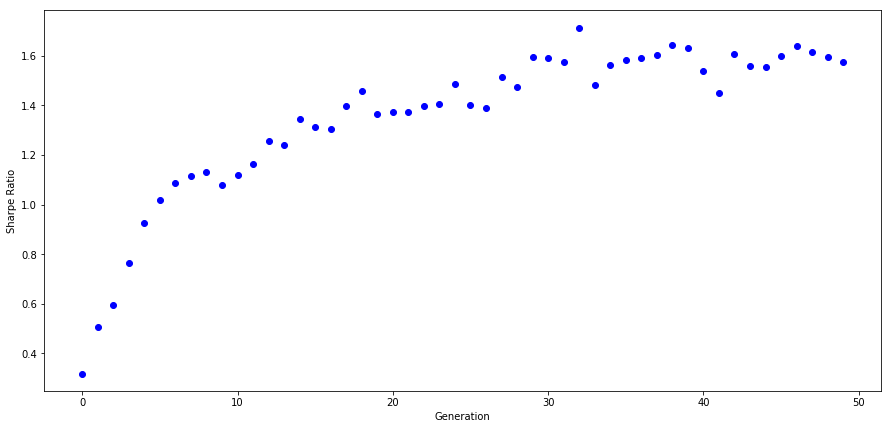

In [214]:
algo = GeneticAlgorithm()
algo.train(50)
algo.plotFitness()

    In sample Sharpe  Out of sample Sharpe
0           1.384140              0.703642
1           1.551529              0.738514
2           1.551529              0.738514
3           1.762006              0.502009
4           1.762006              0.502009
5           1.762006              0.502009
6           1.762006              0.502009
7           1.762006              0.502009
8           1.762006              0.502009
9           1.762006              0.502009
10          1.762006              0.502009
11          1.762006              0.502009
12          1.762006              0.502009
13          1.762006              0.502009
14          1.762006              0.502009
15          1.762006              0.502009
16          1.762006              0.502009
17          1.762006              0.502009
18          1.762006              0.502009
19          1.762006              0.502009
20          1.762006              0.502009
21          1.762006              0.502009
22         

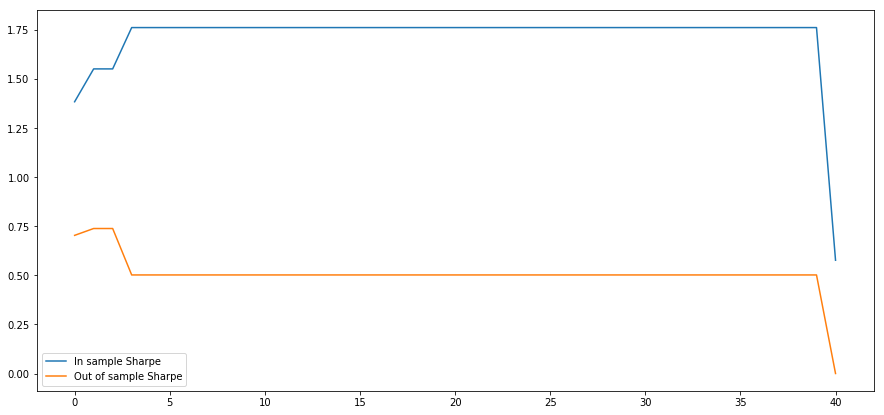

In [215]:
algo.test()

In [217]:
for strat in algo.population.members:
    strat.printRules()
    print()

RSI-sell xor SMA-sell and MOM-sell or Williams %R-sell and MACD-buy
MOM-buy or RSI-buy or Williams %R-buy or OBV-sell or MACD-buy

OBV-sell and MACD-sell and SMA-buy or Williams %R-sell and MACD-buy
Williams %R-buy and RSI-buy or Williams %R-buy and SMA-sell or MACD-buy

RSI-sell or MOM-buy and SMA-sell or Williams %R-sell and MACD-buy
Williams %R-buy or SMA-buy or MOM-buy and MACD-sell xor MACD-buy

MOM-buy xor MOM-buy and SMA-sell or Williams %R-sell and MACD-buy
Williams %R-buy or RSI-buy or Williams %R-buy and OBV-sell xor MACD-buy

RSI-sell and SMA-sell and SMA-sell or Williams %R-sell and MACD-buy
Williams %R-buy or RSI-buy or Williams %R-buy and OBV-sell or MACD-buy

RSI-sell and Bollinger Bands-sell and SMA-buy or Williams %R-sell and MACD-buy
MOM-sell and RSI-buy or Williams %R-buy and OBV-sell or MACD-buy

RSI-sell and SMA-sell and SMA-buy or Williams %R-sell and MACD-buy
Williams %R-buy or RSI-buy or MOM-buy and OBV-sell xor MACD-buy

MOM-buy and CCI-buy xor SMA-buy or Willi